In [35]:
import os
from glob import glob
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reviewing OpenNeuro Meta Data

The meta data were pulled used the access_data and access_functions scripts in this [repo](https://github.com/demidenm/openneuro_scrub/tree/main/scripts). These initial scripts were informed by Dr. Russell Poldrack's [get meta data repo](https://github.com/poldrack/OpenNeuro_analyses/blob/main/metadata_prep/get_metadata.py)

This notebook reviews three separate components related the the files and file content.

1. What frequency are data_description.json, participants.tsv and participant.json files provided
2. What types of column names are provided in the participants.tsv files and what is their frequency
3. For three common columns, sex, gender and handedness, what type of input values are provided?

## Define Some functions

In [5]:
def create_file_existence_df(root_dir, files):
    dfs = []
    
    for root, dirs, files_in_folder in os.walk(root_dir):
        folder_data = []
        
        for file in files:
            folder_data.append({
                'dataset': os.path.basename(root),
                'type': file,
                'exists': file in files_in_folder
            })
        
        # Create a DataFrame for the current folder
        df = pd.DataFrame(folder_data)
        dfs.append(df)
    
    # Concatenate all DataFrames into one
    final_df = pd.concat(dfs, ignore_index=True)
    final_df = final_df[~final_df['dataset'].str.contains('outdata', case=False, na=False)]
    return final_df

def participant_col_list(file_list):
    col_list_df = pd.DataFrame(columns=['study_id', 'column_name'])

    for file in file_list:
        study_id = file.split('/')[-2]
        
        # Attempt to read the file with different encodings
        try:
            dat = pd.read_csv(file, sep='\t', encoding='utf-8')
        except Exception:
            try:
                dat = pd.read_csv(file, sep='\t', on_bad_lines='warn')
            except Exception:
                dat = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
        
        data_rows = [{'study_id': study_id, 'column_name': col} for col in dat.columns]

        # Concatenate data
        col_list_df = pd.concat([col_list_df, pd.DataFrame(data_rows)], ignore_index=True)
    
    return col_list_df

def participant_col_values(file_list, col_list):
    results_df = pd.DataFrame(columns=['study_id', 'column_name', 'values'])

    # lowercase for case-insensitive matching
    columns_lowcase = [col.lower() for col in col_list]

    for file in file_list:
        study_id = file.split('/')[-2]
        
        # Attempt to read the file with different encodings
        try:
            dat = pd.read_csv(file, sep='\t', encoding='utf-8')
        except Exception:
            try:
                dat = pd.read_csv(file, sep='\t', on_bad_lines='warn')
            except Exception:
                dat = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
        
        # Convert column names to lowercase for case-insensitive comparison
        columns_lower = {col.lower(): col for col in dat.columns}
        
        # Find the intersection of target columns with actual columns in the dataframe
        matching_columns = set(columns_lowcase) & set(columns_lower.keys())
        
        # Extract the data for matching columns
        for col_lower in matching_columns:
            actual_col_name = columns_lower[col_lower]
            values = dat[actual_col_name].tolist()  # Convert column values to a list
            
            # Create rows for the DataFrame
            data_rows = [{'study_id': study_id, 
                          'column_name': actual_col_name, 
                          'values': value} for value in values]
            
            # Concatenate data
            results_df = pd.concat([results_df, pd.DataFrame(data_rows)], ignore_index=True)
    
    return results_df


# 1. Availability of three primary files

In [6]:
outdata ='/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata'
opne_folders = glob(f'{outdata}/*')
len(opne_folders)


1152

In [7]:
files_to_check = ["participants.json", "participants.tsv", "dataset_description.json"]

file_existence_df = create_file_existence_df(outdata, files_to_check)

# Save the DataFrame to a CSV file
file_existence_df.to_csv('file_existence_summary.csv', index=False)

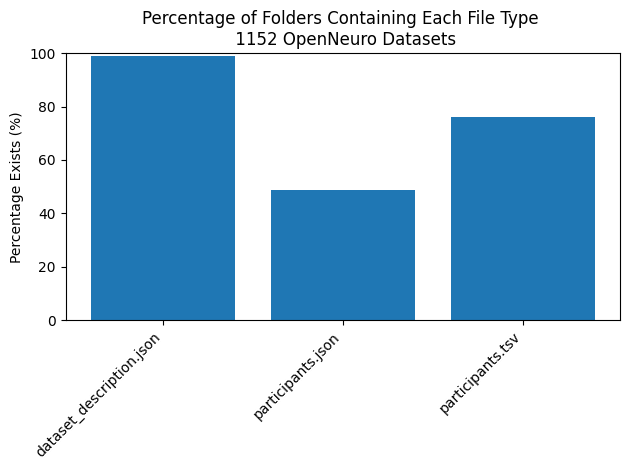

In [8]:
percent_type = file_existence_df.groupby('type')['exists'].mean() * 100
percent_type = percent_type.reset_index()
percent_type.columns = ['type','percent']
plt.bar(percent_type['type'], percent_type['percent'])
plt.xlabel('')
plt.ylabel('Percentage Exists (%)')
plt.title(f'Percentage of Folders Containing Each File Type \n {len(opne_folders)} OpenNeuro Datasets')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 2. Column Types and Frequency in Participants.tsv

In [9]:
file_list = glob(f'{outdata}/**/participants.tsv')
len(file_list)

(878, 'ds005238')

In [11]:
columns_df = participant_col_list(file_list)

b'Skipping line 14: expected 16 fields, saw 17\n'


### Word cloud of words in columns

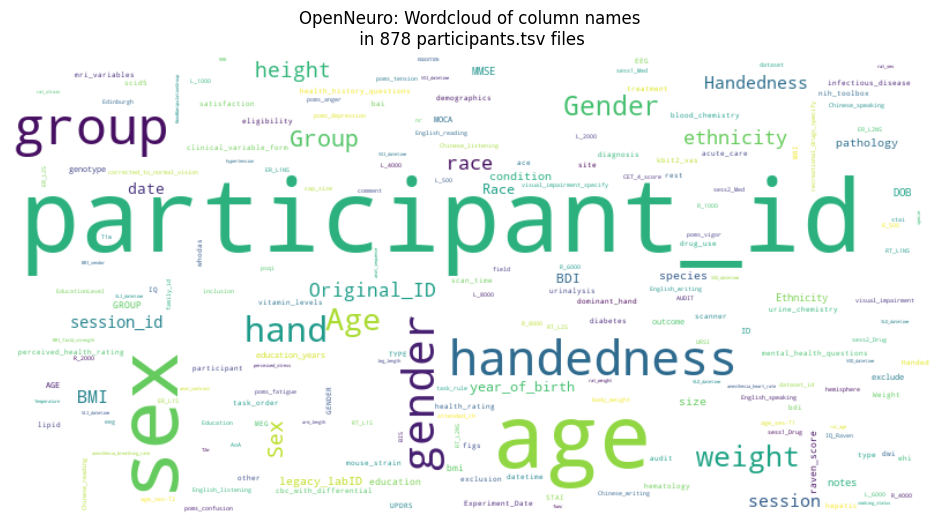

In [12]:
freq_words = Counter(columns_df['column_name'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(freq_words)

# Plot the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'OpenNeuro: Wordcloud of column names \n in {len(file_list)} participants.tsv files ')
plt.show()

### Frequency of words for the top 20 words

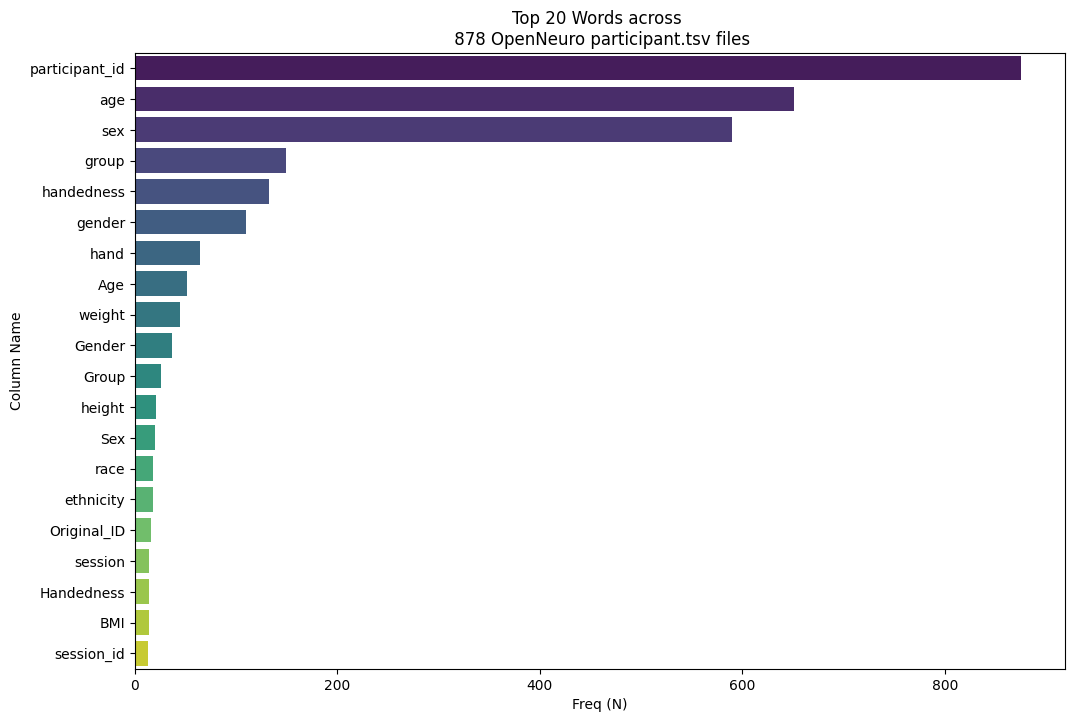

In [52]:
freq_words = Counter(columns_df['column_name'])

# pick top 25
top_25_words = dict(freq_words.most_common(20))
top_words_df = pd.DataFrame(list(top_25_words.items()), columns=['name', 'freq'])


plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Top 20 Words across \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Column Name')
plt.show()

# 3. Types of Values for primary columns

In [14]:
columns_name_eval = ['age','sex','gender','handedness','hand']
columns_values_df = participant_col_values(file_list,columns_name_eval)

b'Skipping line 14: expected 16 fields, saw 17\n'


In [18]:
sex_values = columns_values_df[columns_values_df['column_name']=='sex']
gender_values = columns_values_df[columns_values_df['column_name']=='gender']
handedness = columns_values_df[columns_values_df['column_name']=='handedness']

### Frequncy of values for sex/Sex columns

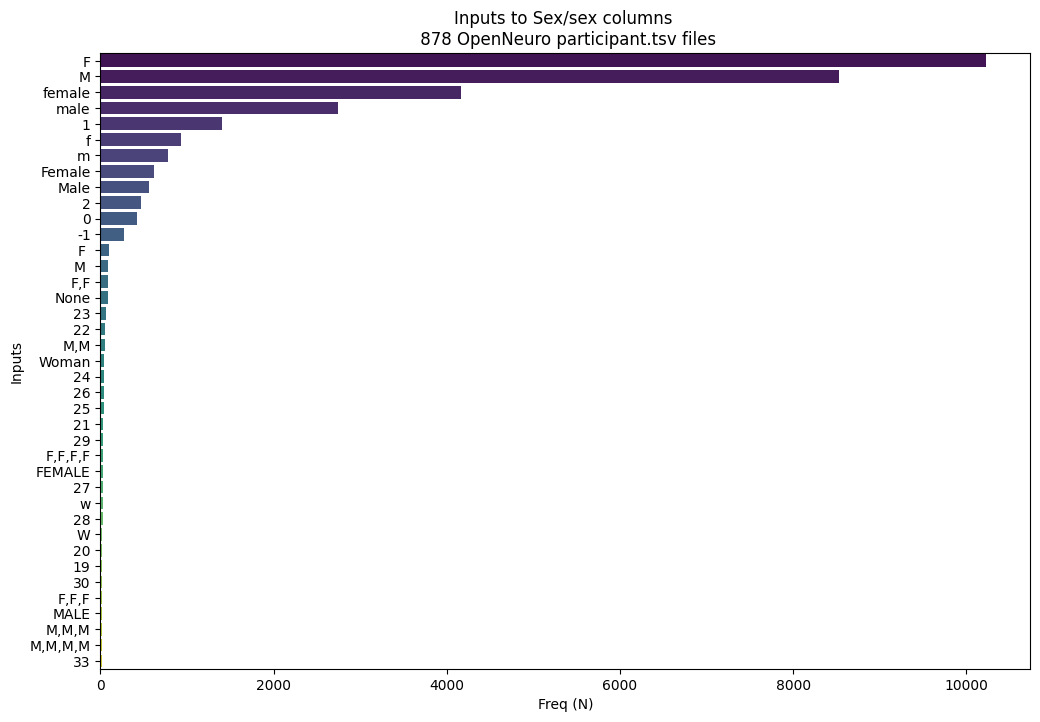

In [27]:
freq_words = Counter(sex_values['values'])

# pick top 40
top_40_words = dict(freq_words.most_common(40))

top_words_df = pd.DataFrame(list(top_40_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to Sex/sex columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Frequncy of values for Gender/gender columns

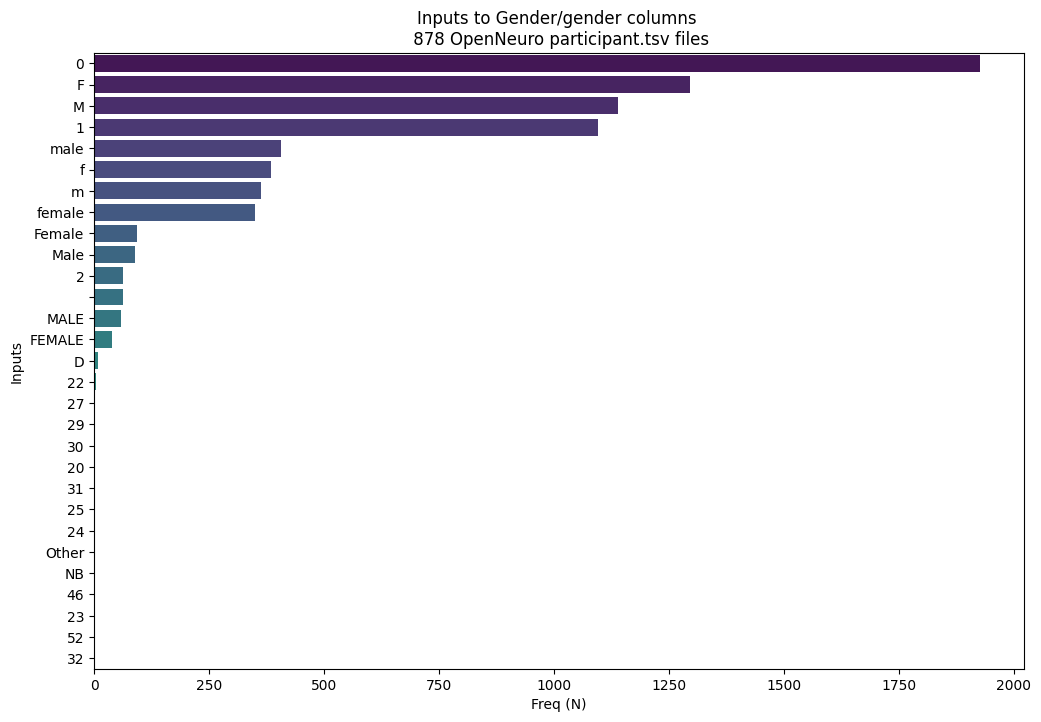

In [30]:
freq_words = Counter(gender_values['values'])

# pick top 30
top_30_words = dict(freq_words.most_common(30))

top_words_df = pd.DataFrame(list(top_30_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to Gender/gender columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Frequncy of values for Handedness/handedness columns

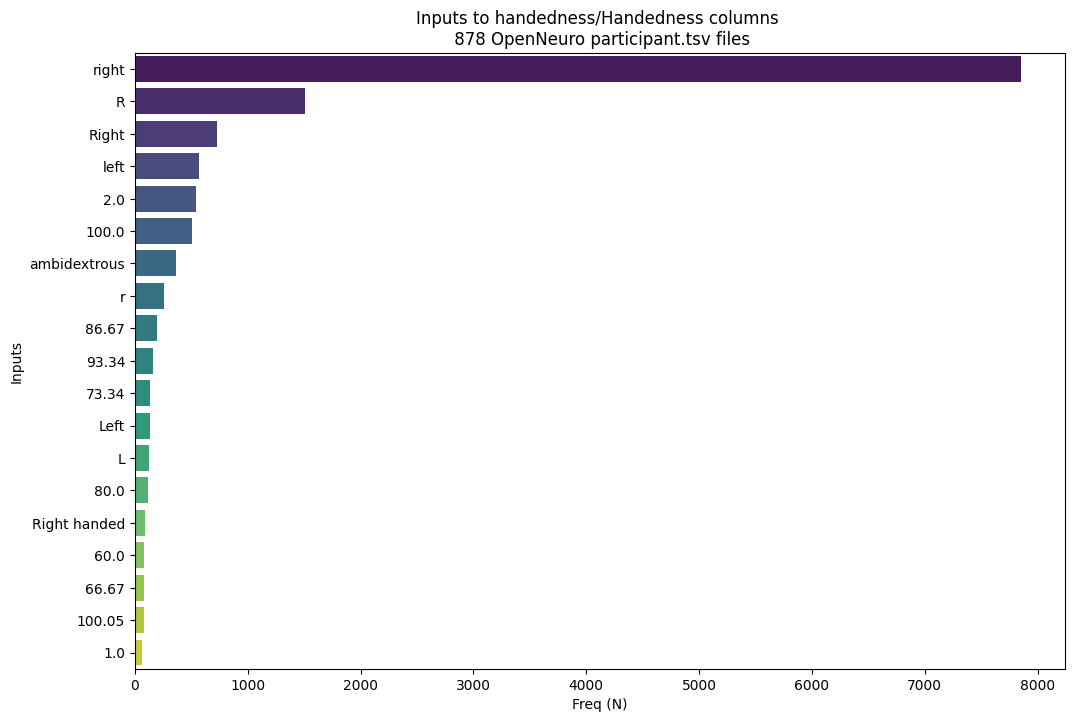

In [53]:
freq_words = Counter(handedness['values'])

top_20_words = dict(freq_words.most_common(20))

top_words_df = pd.DataFrame(list(top_20_words.items()), columns=['name', 'freq'])

#plt 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Inputs to handedness/Handedness columns \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Inputs')
plt.show()

### Inspecting `int` when Expecting `str`

A number of the string variables, such as sex, gender and handedness, have intergers included. Is this a coding error on my part or a data issue?

In [49]:
gender_values[gender_values['values'].apply(lambda x: isinstance(x, int))].sort_values('values')

,study_id,column_name,values
18830,ds003424,gender,0
54441,ds004186,gender,0
54442,ds004186,gender,0
54443,ds004186,gender,0
54444,ds004186,gender,0
...,...,...,...
61719,ds003357,gender,38
61710,ds003357,gender,46
61732,ds003357,gender,51
61713,ds003357,gender,52


Reviewing the above dataset `ds003357`, as it is [available on OpenNeuro](https://openneuro.org/datasets/ds003357/versions/1.0.0/file-display/participants.tsv) there are column names/labels that are flipped. For example gender <--> age. Which is a think that occurs in some other datasets, too.

In [51]:
pd.read_csv( '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds003357/participants.tsv',
sep='\t')

,participant_id,group,gender,age
0,sub-01,biofeedback,31,F
1,sub-02,biofeedback,22,F
2,sub-03,biofeedback,25,F
3,sub-04,biofeedback,46,M
4,sub-05,biofeedback,27,F
5,sub-06,biofeedback,23,M
6,sub-07,biofeedback,52,M
7,sub-08,biofeedback,29,M
8,sub-09,biofeedback,27,M
9,sub-10,biofeedback,32,F


In [50]:
file_list

['/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds005238/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds003799/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds004910/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds002674/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds005207/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds001653/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds003104/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds001461/participants.tsv',
 '/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata/ds002680/pa